# 라이브러리 로드

In [1]:
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from numpy.testing import assert_allclose

import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, LSTM, Dropout

# 데이터 로드

In [2]:
df = pd.read_csv('SMILES_bp.csv')
df.head()

,SMILES,bp
0,C,-161.5
1,CC,-88.5
2,CCC,-42.0
3,CCCC,-1.0
4,CCCCC,36.0


## Y 값의 분포 확인

In [3]:
Y = df['bp']

Text(0.5, 0, 'BP (°C)')

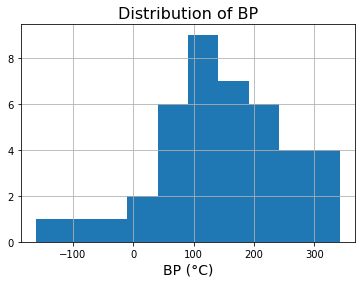

In [4]:
pd.Series(Y).hist()
plt.title('Distribution of BP', fontsize=16)
plt.xlabel('BP (°C)', fontsize = 14)

# SMILES 전처리
SMILES의 시작을 '!', 끝을 'E'로 표시

In [5]:
smiles = df['SMILES'].values
smiles[:5]

array(['C', 'CC', 'CCC', 'CCCC', 'CCCCC'], dtype=object)

In [6]:
smiles = [i.replace('\n', '') for i in smiles]
smiles = [ '!' + i + 'E' for i in smiles]
smiles[:5]

['!CE', '!CCE', '!CCCE', '!CCCCE', '!CCCCCE']

## SMILES 데이터의 특징 확인

In [7]:
full_smiles = ''
for i in smiles:
    full_smiles +=i

In [8]:
from collections import Counter

chars = ' '.join(list(full_smiles))

# create a list of characters
chars_list = chars.split()

# Count all the words using Counter Method
count_chars = Counter(chars_list)

total_chars = len(chars_list)
sorted_chars = count_chars.most_common(total_chars)

## 정수 인코딩

In [9]:
# SMILES 를 이루는 characters 확인
unique_chars = sorted(list(set(full_smiles))) 

# Character ↔ index Mapping
char_to_int = dict((c, i) for i, c in enumerate(unique_chars)) # character → index
int_to_char = dict((i, c) for i, c in enumerate(unique_chars)) # index → character

In [10]:
char_to_int

{'!': 0,
 '(': 1,
 ')': 2,
 '1': 3,
 '2': 4,
 '=': 5,
 'C': 6,
 'E': 7,
 'N': 8,
 'O': 9,
 'c': 10}

In [11]:
int_to_char

{0: '!',
 1: '(',
 2: ')',
 3: '1',
 4: '2',
 5: '=',
 6: 'C',
 7: 'E',
 8: 'N',
 9: 'O',
 10: 'c'}

정수 인코딩, 디코딩을 위한 딕셔너리의 길이 확인

In [12]:
mapping_size = len(char_to_int)
reverse_mapping_size = len(int_to_char)

print ("Size of the character to integer dictionary is: ", mapping_size)
print ("Size of the integer to character dictionary is: ", reverse_mapping_size)

Size of the character to integer dictionary is:  11
Size of the integer to character dictionary is:  11


In [13]:
# Summarize the loaded data to provide lengths for preparing datasets
n_chars = len(full_smiles)
n_vocab = len(unique_chars)

print("Total number of characters in the file is: ", n_chars) # 한 분자당 !, E 포함되어있음

Total number of characters in the file is:  440


In [14]:
smiles_num_list = []
for wax in smiles:
    r = [ char_to_int[w] for w in list(wax) ]
    
    
    smiles_num_list.append(r)

## 정수 인코딩된 SMILES 의 표현 예시

In [15]:
print(smiles_num_list[0:5])

[[0, 6, 7], [0, 6, 6, 7], [0, 6, 6, 6, 7], [0, 6, 6, 6, 6, 7], [0, 6, 6, 6, 6, 6, 7]]


In [16]:
type(full_smiles)

str

In [17]:
' '.join(list(full_smiles))

'! C E ! C C E ! C C C E ! C C C C E ! C C C C C E ! C C C C C C E ! C C C C C C C E ! C C C C C C C C E ! C C C C C C C C C E ! C C C C C C C C C C E ! C C C C C C C C C C C E ! C C C C C C C C C C C C E ! C C C C C C C C C C C C C E ! C C C C C C C C C C C C C C E ! C C C C C C C C C C C C C C C E ! C C C C C C C C C C C C C C C C E ! C C C C C C C C C C C C C C C C C E ! C C C C C C C C C C C C C C C C C C E ! C C C C C C C C C C C C C C C C C C C E ! C C C C C C C C C C C C C C C C C C C C E ! O E ! C O E ! C C O E ! C C C O E ! C C C C O E ! C C C C C O E ! C C C C C C O E ! C C C C C C C O E ! O C C O E ! O C C C O E ! C C ( O ) C O E ! O C C ( O ) C O E ! c 1 c c c c c 1 E ! C c 1 c c c c c 1 E ! C 1 C C C C C 1 E ! C = C c 1 c c c c c 1 E ! c 1 c c c 2 c c c c c 2 c 1 E ! C C c 1 c c c c c 1 E ! N c 1 c c c c c 1 E ! C c 1 c c c ( C ) c c 1 E ! C C ( = O ) C E'

In [18]:
from collections import Counter
#all_text2 = list(smiles)

# create a list of words
words = ' '.join(list(full_smiles))

# Count all the words using Counter Method
count_words = Counter(words)

total_words = len(words)
sorted_words = count_words.most_common(total_words)

del(count_words[' ']) # 공백은 집계대상 아님

In [19]:
print(count_words)

Counter({'C': 265, 'c': 46, '!': 41, 'E': 41, 'O': 18, '1': 16, '(': 4, ')': 4, '=': 2, '2': 2, 'N': 1})


Text(0.5, 1.0, 'Token Frequency')

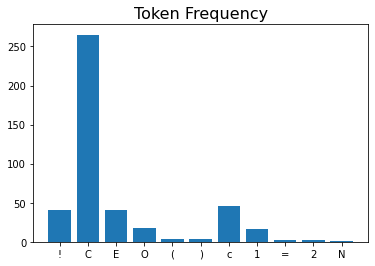

In [20]:
plt.bar(range(len(count_words)), list(count_words.values()), align='center')
plt.xticks(range(len(count_words)), list(count_words.keys()))
plt.title('Token Frequency', fontsize = 16)

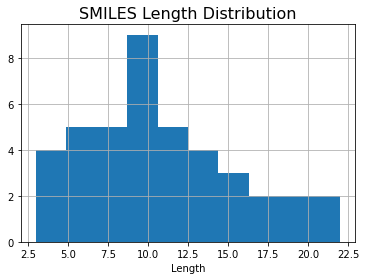

count    41.000000
mean     10.731707
std       5.005119
min       3.000000
25%       7.000000
50%      10.000000
75%      14.000000
max      22.000000
dtype: float64

In [21]:
%matplotlib inline
wax_len = [len(x) for x in smiles_num_list]
pd.Series(wax_len).hist()
plt.title('SMILES Length Distribution', fontsize=16)
plt.xlabel('Length')
plt.show()
pd.Series(wax_len).describe()

# Padding

In [22]:
def pad_features(smiles_num_list, max_seq_length):
    ''' Return features of review_ints, where each review is padded with 0's or truncated to the input seq_length.
    '''
    features = np.zeros((len(smiles_num_list), max_seq_length), dtype = int)
    
    for i, wax in enumerate(smiles_num_list):
        wax_len = len(wax)
        
        if wax_len <= max_seq_length:
            zeroes = list(np.zeros(max_seq_length-wax_len))
            new = zeroes+wax
        elif wax_len > max_seq_length:
            new = smiles[0:max_seq_length]
        
        features[i,:] = np.array(new)
    
    return features

In [23]:
max_seq_length = max([len(a) for a in smiles_num_list])

In [24]:
for i, wax in enumerate(smiles_num_list):
    wax_len = len(wax)
    #print(wax_len)
    
    if wax_len <= max_seq_length:
        zeros = list(np.zeros(max_seq_length-wax_len))
        new = zeros+wax
        print(new)

[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0, 6, 7]
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0, 6, 6, 7]
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0, 6, 6, 6, 7]
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0, 6, 6, 6, 6, 7]
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0, 6, 6, 6, 6, 6, 7]
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0, 6, 6, 6, 6, 6, 6, 7]
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0, 6, 6, 6, 6, 6, 6, 6, 7]
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0, 6, 6, 6, 6, 6, 6, 6, 6, 7]
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0, 6, 6, 6, 6, 6, 6, 6, 6, 6, 7]
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 7]
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,

In [25]:
features = pad_features(smiles_num_list, max_seq_length)
features

array([[ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  6,  7],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  6,  6,  7],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  6,  6,  6,  7],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  6,  6,  6,  6,  7],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         6,  6,  6,  6,  6,  7],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  6,
         6,  6,  6,  6,  6,  7],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  6,  6,
         6,  6,  6,  6,  6,  7],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  6,  6,  6,
         6,  6,  6,  6,  6,  7],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  6,  6,  6,  6,
         6,  6,  6,  6,  6,  7],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  6,

In [26]:
x=features.reshape(features.shape[0],features.shape[1],1)

In [27]:
features.shape

(41, 22)

In [28]:
a = np.array(list(range(len(char_to_int))))
a = a.reshape(-1,1)

In [29]:
from sklearn.preprocessing import OneHotEncoder
enc = OneHotEncoder()
enc.fit(a)

OneHotEncoder()

x를 원핫으로 변경

In [30]:
x_onehot = np.zeros((len(smiles), max_seq_length, len(char_to_int)))
for i in range(len(smiles)):
    x_onehot[i] = enc.transform(x[i]).toarray().reshape(max_seq_length,-1)

In [31]:
x_onehot.shape

(41, 22, 11)

In [32]:
x_onehot[0]

array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.

In [33]:
x.shape

(41, 22, 1)

In [34]:
## Training, Validation, Test set split

In [35]:
from sklearn.model_selection import train_test_split

In [36]:
x_train, x_test, y_train, y_test = train_test_split(x_onehot, Y, test_size=0.1, shuffle=True, random_state=210615)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.11, shuffle=True, random_state=210615)

In [37]:
print('training set data:',x_train.shape)
print('training set label:',y_train.shape)

print('validation set data:',x_val.shape)
print('validation set data:',y_val.shape)

print('test set data:',x_test.shape)
print('test set label:',y_test.shape)

training set data: (32, 22, 11)
training set label: (32,)
validation set data: (4, 22, 11)
validation set data: (4,)
test set data: (5, 22, 11)
test set label: (5,)


In [38]:
x_train.shape

(32, 22, 11)

In [39]:
gpu_devices = tf.config.experimental.list_physical_devices('GPU')
#tf.config.experimental.set_memory_growth(gpu_devices[0], enable=True)
for device in gpu_devices:
    tf.config.experimental.set_memory_growth(device, True)

# LSTM 학습

## Early stop 을 위한 call back

In [40]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=1000, verbose=0, mode='auto',restore_best_weights=True)

## Model build

In [41]:
"""CREATING THE LSTM MODEL"""

# Create the model (simple 2 layer LSTM)
model = Sequential()
model.add(LSTM(20, input_shape=(None, x_train.shape[2]), return_sequences = False))
model.add(Dense(10, activation ='sigmoid'))
model.add(Dense(1))

model.compile(loss = 'mse', optimizer='adam')

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 20)                2560      
_________________________________________________________________
dense (Dense)                (None, 10)                210       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 11        
Total params: 2,781
Trainable params: 2,781
Non-trainable params: 0
_________________________________________________________________


## Training

In [42]:
%%time
tf_device = '/GPU:1'
training = model.fit(x_train, y_train, epochs = 50000, validation_data=(x_val, y_val), batch_size = 10, callbacks=[early_stopping], verbose=0)

CPU times: user 14min 48s, sys: 1min 1s, total: 15min 50s
Wall time: 12min 10s


# Result

(319.658154296875, 1633.2819213867188)

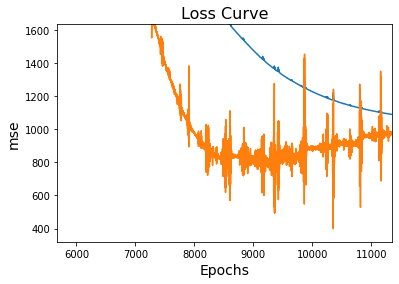

In [51]:
plt.plot(training.history['loss'])
plt.plot(training.history['val_loss'])
plt.title('Loss Curve', fontsize = 16)
plt.xlabel('Epochs', fontsize = 14)
plt.ylabel('mse', fontsize = 14)
plt.xlim([0.5*len(training.history['loss']), len(training.history['loss'])])
plt.ylim([0.8*min(training.history['val_loss']), 1.5*min(training.history['loss'])])

## Parity plot

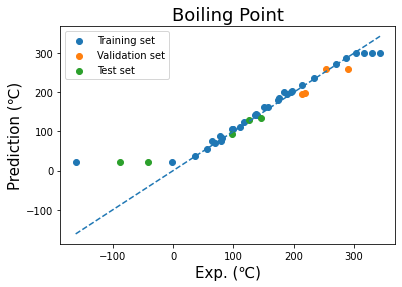

In [52]:
plt.scatter(y_train,model.predict(x_train))
plt.scatter(y_val,model.predict(x_val))
#plt.legend(['Validation set','Test set'])
plt.scatter(y_test,model.predict(x_test))


plt.title('Boiling Point', fontsize = 18)
plt.ylabel('Prediction (℃)', fontsize=15)
plt.xlabel('Exp. (℃)', fontsize=15)

plt.legend(['Training set','Validation set','Test set'])
plt.plot([min(Y),max(Y)],[min(Y),max(Y)],'--')